In [5]:
from zipline import run_algorithm
import matplotlib.pyplot as plt
import math
from zipline.api import (order_target_percent,symbol,set_commission,set_benchmark,order,record)
import numpy as np
from zipline.finance.commission import PerTrade
import pandas as pd
from zipline.api import order_target, record, symbol, set_commission, set_slippage, set_long_only,order_target_percent, order, schedule_function,  date_rules,time_rules
from zipline.finance import commission
import warnings
import matplotlib.pyplot as plt
from zipline.utils.calendar_utils import get_calendar
# import talib
# from talib import MACD # type: ignore
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')
import sys
import os
root_dir = os.getcwd().replace('/Notebooks','')
sys.path.insert(1, root_dir)
from zipline.utils.run_algo import load_extensions
#from utils.utils import *
from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, INFO, WARNING, DEBUG, ERROR)
import pytz
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
%matplotlib inline
import matplotlib.pyplot as plt
import quantstats as qs

/home/popeye/.local/lib/python3.10/site-packages/quantstats/utils.py:300: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic("matplotlib inline")


In [2]:
calendar_name = 'NYSE'
calendar = get_calendar(calendar_name)

## Bollinger Bands

In [15]:
def initialize(context):
    context.i = 0
    context.asset = symbol("GOOGL")

def handle_data(context, data):
    buy_signal = False
    sell_signal = False

    price_history = data.history(context.asset, 'close', 20, '1d')
    current_price = data.current(context.asset, 'close')

    sma = price_history.mean()
    std = price_history.std()

    upper_band = sma + (2*std)
    lower_band = sma - (2*std)

    context.bollinger_bands = (lower_band, upper_band)
    
    if current_price <= 0.8*lower_band:
        order(context.asset, 1.0)
        buy_signal = True
    elif current_price >= 0.75*upper_band:
        order(context.asset, -1.0)
        sell_signal = True
    else:
        order(context.asset, 0)
    
    record(price = current_price, lower_band = lower_band, upper_band = upper_band)

### Bollinger Band in other way

In [34]:
from zipline.api import order, symbol
import pandas as pd

def calculate_bollinger_bands(prices, window_size=20, num_std_dev=3):
    rolling_mean = prices.rolling(window=window_size).mean()
    rolling_std = prices.rolling(window=window_size).std()

    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)

    return upper_band, lower_band

def initialize(context):
    context.asset = symbol("GOOGL")  
    context.set_commission(commission.PerShare(cost=0.0075, min_trade_cost=1.0))

def handle_data(context, data):
   
    prices = data.history(context.asset, 'price', bar_count=50, frequency='1d')

    upper_band, lower_band = calculate_bollinger_bands(prices)

    # Get the current price
    current_price = data.current(context.asset, 'price')

    # Generate signals
    if current_price > upper_band[-1]:
        order(context.asset, -1)  
    elif current_price < lower_band[-1]:
        order(context.asset, 1)   
    record(
        upper_band=upper_band[-1],
        lower_band=lower_band[-1],
        current_price=current_price
    )


In [37]:
start_date = pd.to_datetime('2015-01-01 00:00:00.0000', format = '%Y-%m-%d %H:%M:%S.%f')
end_date = pd.to_datetime('2021-01-01 00:00:00.0000',format = '%Y-%m-%d %H:%M:%S.%f')
results = run_algorithm(start=start_date,
                            end=end_date,
                            initialize=initialize,
                            handle_data=handle_data,
                            capital_base=10000,
                            benchmark_returns=None,
                            trading_calendar=calendar,
                            bundle='spStocks',
                            data_frequency='daily',
                            )

/home/popeye/.local/lib/python3.10/site-packages/zipline/data/data_portal.py:951: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/tmp/ipykernel_5954/1732454722.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if current_price > upper_band[-1]:
/tmp/ipykernel_5954/1732454722.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif current_price < lower_band[-1]:
/tmp/ipykernel_5954/1732454722.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a futur

/home/popeye/.local/lib/python3.10/site-packages/quantstats/reports.py:933: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  _stats.expected_return(df, compounded=compounded, prepare_returns=False) * pct
/home/popeye/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/popeye/.local/lib/python3.10/site-packages/quantstats/reports.py:936: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  _stats.expected_return(df, compounded=compounded, aggregate="M", prepare_returns=False) * pct
/home/popeye/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86:

                           Strategy
-------------------------  ----------
Start Period               2015-01-05
End Period                 2020-12-31
Risk-Free Rate             0.0%
Time in Market             65.0%

Cumulative Return          -0.17%
CAGR﹪                     -0.02%

Sharpe                     -0.25
Prob. Sharpe Ratio         27.49%
Smart Sharpe               -0.2
Sortino                    -0.37
Smart Sortino              -0.31
Sortino/√2                 -0.26
Smart Sortino/√2           -0.22
Omega                      0.94

Max Drawdown               -0.34%
Longest DD Days            1955
Volatility (ann.)          0.11%
Calmar                     -0.06
Skew                       1.0
Kurtosis                   19.68

Expected Daily %           -0.0%
Expected Monthly %         -0.0%
Expected Yearly %          -0.03%
Kelly Criterion            -3.01%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.01%
Expected Shortfall (cVaR)  -0.01%

Max Consecutive Wins

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-08-26,2018-07-26,2020-12-31,1955,-0.336409,-0.314226
2,2015-07-27,2015-08-17,2015-08-20,25,-0.019678,-0.019638
3,2015-07-20,2015-07-21,2015-07-23,4,-0.011433,-0.011303


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


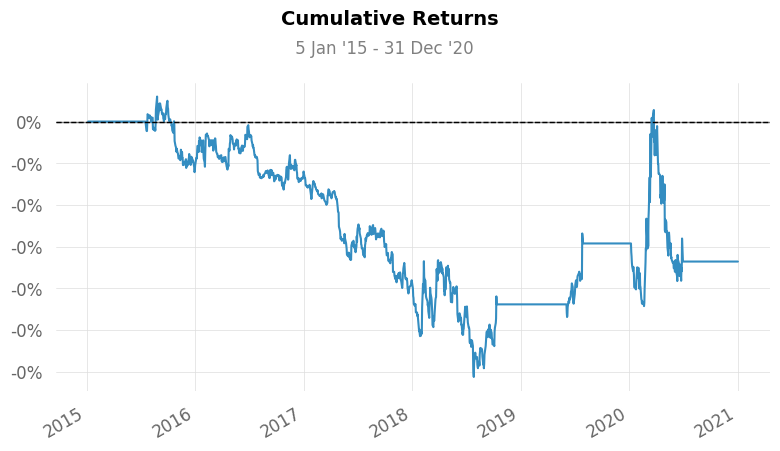

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


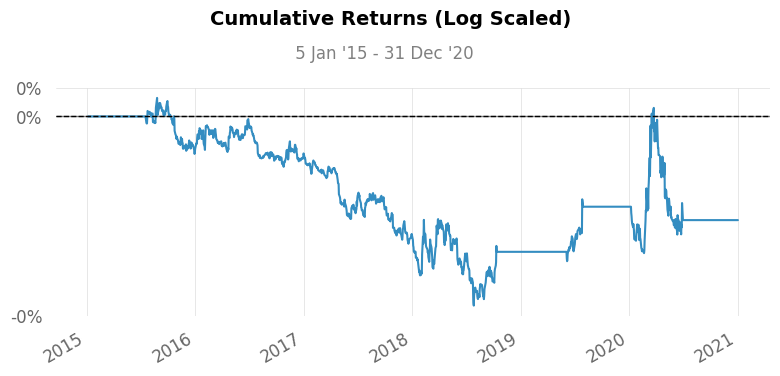

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


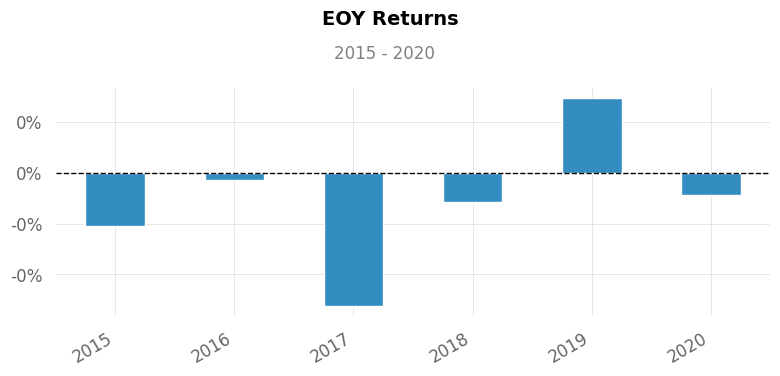

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


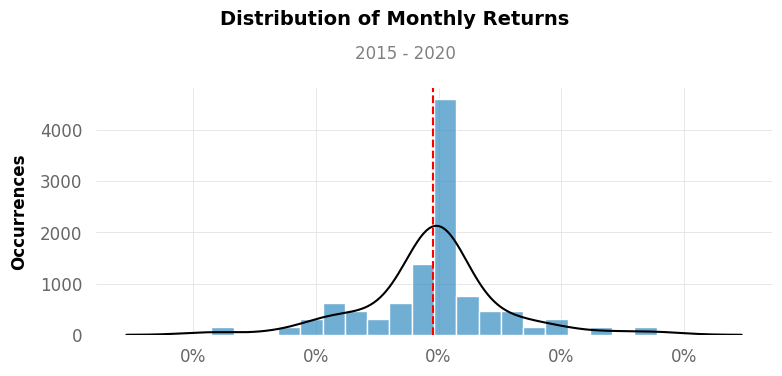

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


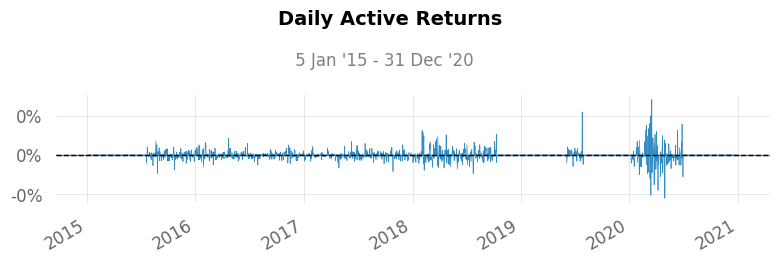

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


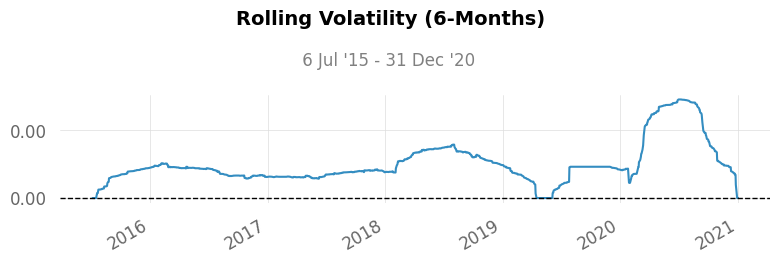

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


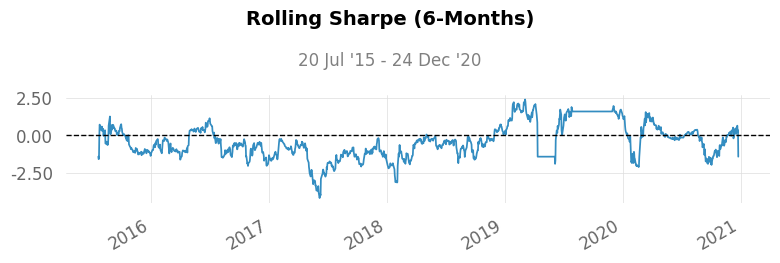

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


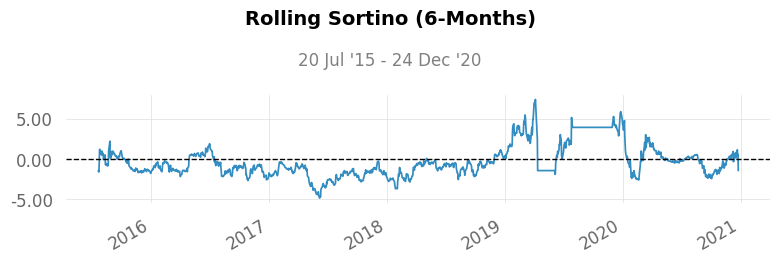

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


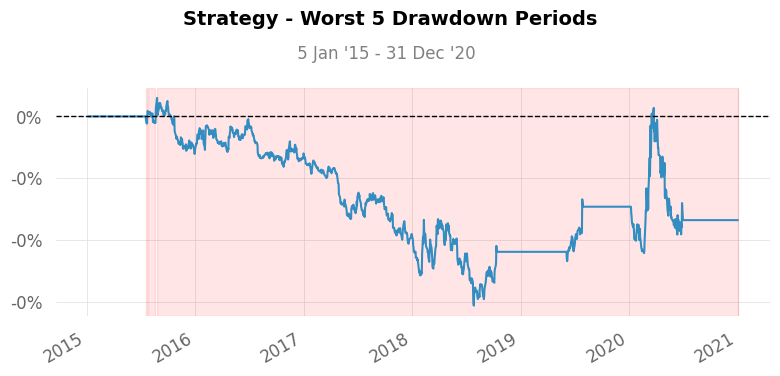

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


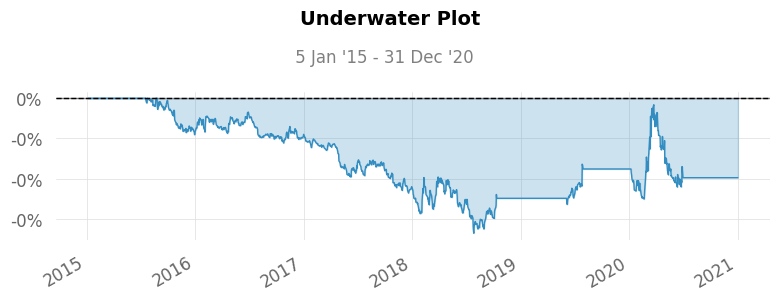

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


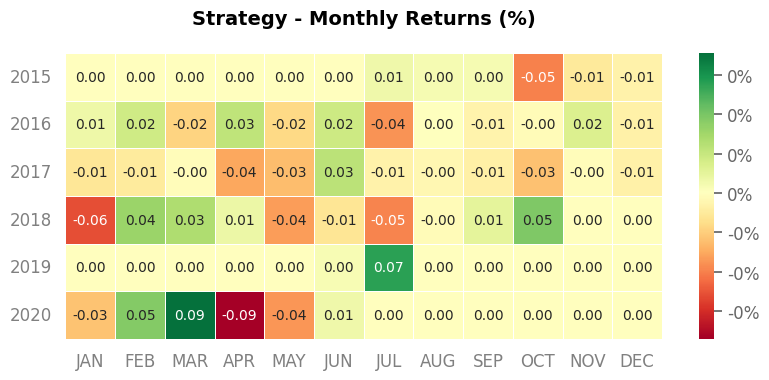

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


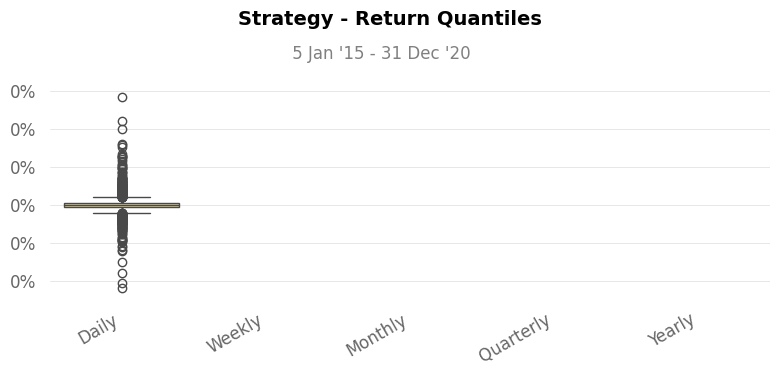

In [38]:
returns = results['portfolio_value'].pct_change().dropna()
qs.reports.full(returns)